In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
from sklearn.cluster import KMeans
import maxflow


# Load Image
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

# Initialize Labels using K-Means
def initialize_labels(image, K=3):
    h, w, c = image.shape
    pixels = image.reshape((-1, 3))  # Flatten image to (num_pixels, 3)
    
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)  # Assign labels to pixels
    
    return labels.reshape((h, w))  # Reshape back to image dimensions

# Display Initial Segmentation with Unique Colors per Label
def show_segmentation(image, labels, K=3):
    h, w = labels.shape
    segmented_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Assign a unique random color to each label
    np.random.seed(42)  # For consistent colors
    colors = np.random.randint(0, 255, size=(K, 3), dtype=np.uint8)

    for k in range(K):
        segmented_image[labels == k] = colors[k]

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title("Segmented Image")
    plt.axis("off")

    plt.show()

# Compute Color Histograms for Each Label
def compute_histograms(image, labels, K, bins=16):
    histograms = []
    for k in range(K):
        mask = (labels == k)
        pixels = image[mask]
        hist = np.histogramdd(pixels, bins=bins, range=[(0, 256), (0, 256), (0, 256)])[0]
        histograms.append(hist / np.sum(hist))  # Normalize histogram
    return histograms

# Compute Unary Term Using Histograms
def compute_unary_term(image, labels, histograms, K, bins=16):
    h, w, c = image.shape
    unary = np.zeros((h, w, K))
    
    for k in range(K):
        hist = histograms[k]
        for i in range(h):
            for j in range(w):
                pixel = image[i, j]
                bin_idx = np.floor(pixel / bins).astype(int)  # Map pixel to histogram bin
                unary[i, j, k] = -np.log(hist[bin_idx[0], bin_idx[1], bin_idx[2]] + 1e-8)  # Avoid log(0)
    
    return unary

# Compute Pairwise Term Using Potts Model
def compute_pairwise_term(image, K, lambda_val=1.0):
    h, w, _ = image.shape
    pairwise = np.zeros((h, w, K, K))
    
    for i in range(h - 1):
        for j in range(w - 1):
            for k1 in range(K):
                for k2 in range(K):
                    pairwise[i, j, k1, k2] = lambda_val * (k1 != k2)  # Potts model penalty
    
    return pairwise


def initialize_labels_bis(image, K, method='kmeans'):
    """
    Initialize the segmentation labels.
    
    Args:
        image: Input image (h, w, channels)
        K: Number of labels
        method: 'kmeans' or 'random'
    
    Returns:
        Initial labels (h, w)
    """
    h, w, c = image.shape
    pixels = image.reshape(-1, c)
    
    if method == 'random':
        return np.random.randint(0, K, (h, w))
    elif method == 'kmeans':
        kmeans = KMeans(n_clusters=K, random_state=0).fit(pixels)
        return kmeans.labels_.reshape(h, w)
    else:
        raise ValueError(f"Unknown initialization method: {method}")



# Alpha-Expansion Graph Cut using PyMaxflow
def alpha_expansion(image,unary, pairwise, K, method='kmeans', max_iterations=20):
    h, w, _ = image.shape
    # labels = np.argmin(unary, axis=2)  # Initialize labels using unary term
    # labels = initialize_labels_bis(image,method=method, K=K)
    labels = np.argmin(unary, axis=2)
    show_segmentation(image, labels)
    for _ in range(max_iterations):
        print(f"iterations nb: {_}")
        for alpha in range(K):
            print(f"alpha: {alpha}")
            graph = maxflow.Graph[float]()
            nodes = graph.add_nodes(h * w)
        
            for i in range(h):
                for j in range(w):
            # Add unary terms
                    pixel_index = i * w + j
                    if labels[i, j] == alpha:
                        graph.add_tedge(nodes[pixel_index], unary[i, j, alpha], np.inf)  # Keep alpha pixels fixed
                    else:
                        graph.add_tedge(nodes[pixel_index], unary[i, j, alpha], unary[i, j, labels[i, j]])
            
            # Add pairwise terms
                    if i < h-1:
                        neighbor_index_down = pixel_index + w
                        
                        weight_down = pairwise[i, j, labels[i, j], alpha]

                        if labels[i,j] != labels[i+1,j]:
                            aux_node = graph.add_nodes(1)
                            graph.add_edge(nodes[pixel_index], aux_node, weight_down, weight_down)
                            graph.add_edge(nodes[neighbor_index_down], aux_node, pairwise[i+1,j,labels[i+1,j],alpha], pairwise[i+1,j,labels[i+1,j],alpha])
                        
                            graph.add_tedge(aux_node, 0, weight_down)

                        else:
                            graph.add_edge(nodes[pixel_index], nodes[neighbor_index_down], weight_down, weight_down)
                        
                    if j < w-1:
                        neighbor_index_right = pixel_index + 1
                        weight_right = pairwise[i, j, labels[i, j], alpha]
                        if labels[i,j] != labels[i,j+1]:
                            aux_node = graph.add_nodes(1)
                            graph.add_edge(nodes[pixel_index], aux_node, weight_right, weight_right)
                            graph.add_edge(nodes[neighbor_index_right],aux_node, pairwise[i,j+1,labels[i,j+1],alpha], pairwise[i,j+1,labels[i,j+1],alpha])
                            graph.add_tedge(aux_node, 0, weight_right)
                        else:
                            graph.add_edge(nodes[pixel_index], nodes[neighbor_index_right], weight_right, weight_right)

        
            # Compute min-cut
            graph.maxflow()
            
            # Update labels
            for i in range(h):
                for j in range(w):
                    pixel_index = i * w + j
                    if graph.get_segment(nodes[pixel_index]) == 0:
                        labels[i, j] = alpha  # Expand α-region

            show_segmentation(image, labels, K)
        if _ % 5 == 0:
            show_segmentation(image, labels, K)
    return labels

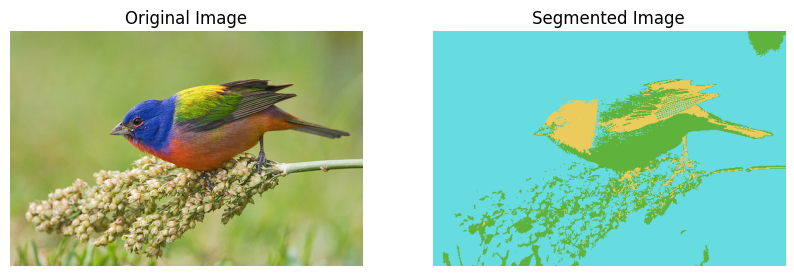

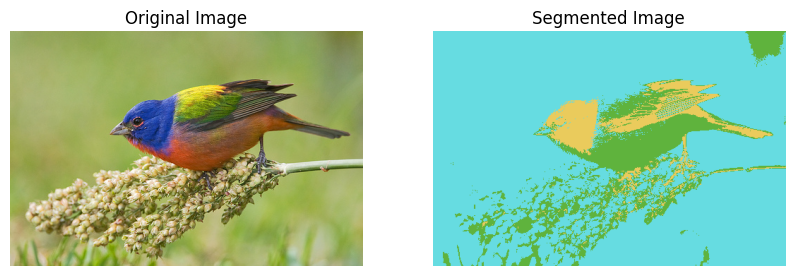

iterations nb: 0
alpha: 0


C:\Users\ab910\AppData\Local\Temp\ipykernel_17640\4222175250.py:146: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  graph.add_edge(nodes[pixel_index], aux_node, weight_down, weight_down)
C:\Users\ab910\AppData\Local\Temp\ipykernel_17640\4222175250.py:147: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  graph.add_edge(nodes[neighbor_index_down], aux_node, pairwise[i+1,j,labels[i+1,j],alpha], pairwise[i+1,j,labels[i+1,j],alpha])
C:\Users\ab910\AppData\Local\Temp\ipykernel_17640\4222175250.py:149: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element fro

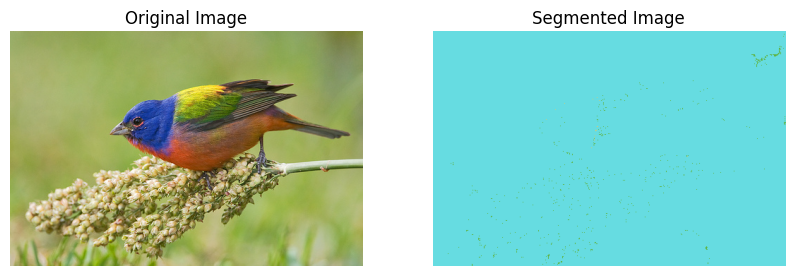

alpha: 1


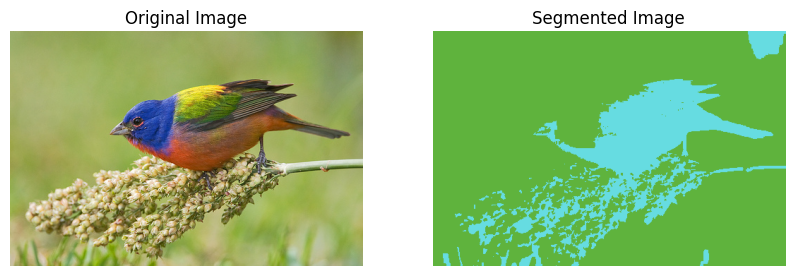

alpha: 2


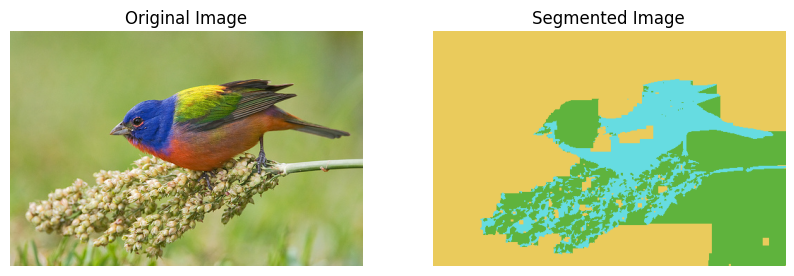

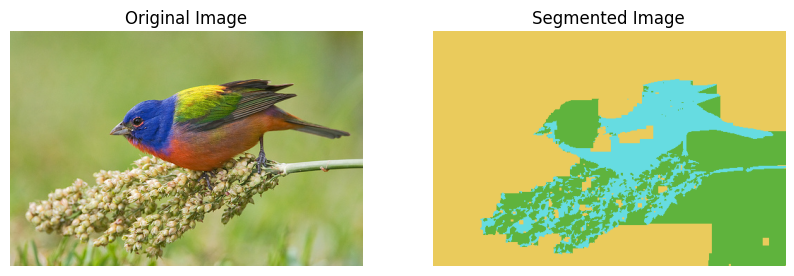

iterations nb: 1
alpha: 0


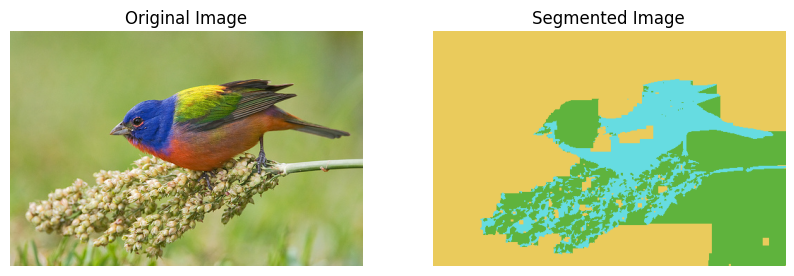

alpha: 1


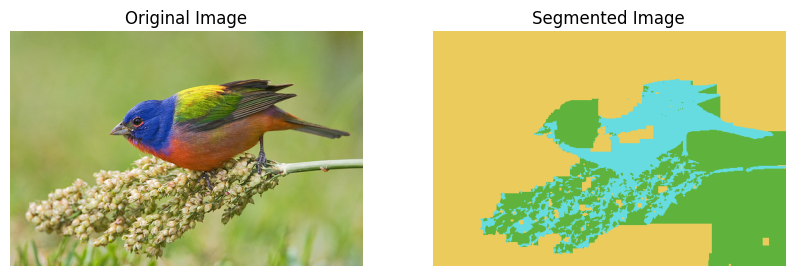

alpha: 2


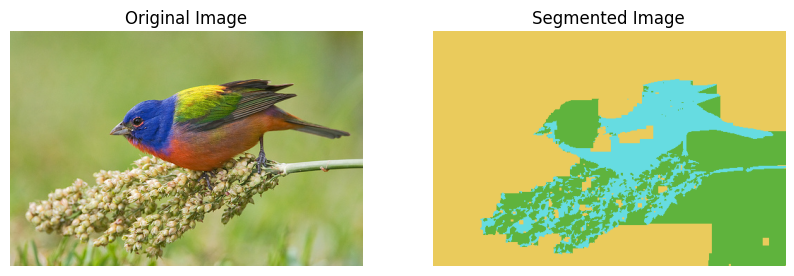

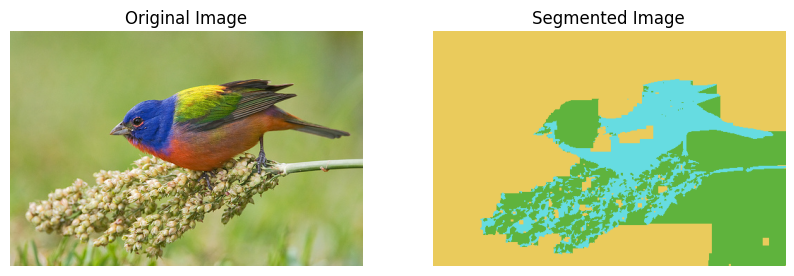

In [2]:
image_path = "images/bird1.jpg"  # Replace with actual image path
K=3
image = load_image(image_path)
labels = initialize_labels_bis(image, K=K, method='kmeans')
show_segmentation(image, labels)

histograms = compute_histograms(image, labels, K=K, bins = 16)
unary_term = compute_unary_term(image, labels,histograms, K=K, bins=16)
pairwise_term = compute_pairwise_term(image, K=K, lambda_val=5)
segmented_labels = alpha_expansion(image, unary_term, pairwise_term,method='kmeans', K=K,max_iterations=2)
show_segmentation(image, segmented_labels)